In [35]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import json
from tqdm.notebook import tqdm
tqdm.pandas()

import math


%matplotlib inline

In [2]:
def add_velocity_and_distance(row):
    duration = row['duration']
    start_point = row['source_geometry']
    end_point = row['target_geometry']
    line_distance = start_point.distance(end_point)
    line_velocity = line_distance / (duration / 60 / 60) / 1000 if duration > 0 else 60
    mid_x = (start_point.coords[0][0] + end_point.coords[0][0]) / 2
    mid_y = (start_point.coords[0][1] + end_point.coords[0][1]) / 2
    midpoint = Point(mid_x, mid_y)
    row['line_distance'] = line_distance
    row['line_velocity'] = line_velocity
    row['geometry'] = midpoint
    return row

In [3]:
routes_od = pd.read_csv("dane/routes.txt")
stops_od = pd.read_csv("dane/stops.txt")
shapes_od = pd.read_csv("dane/shapes.txt")
trips_od = pd.read_csv("dane/trips.txt")
stop_times_od = pd.read_csv("dane/stop_times.txt")

stops_od = gpd.GeoDataFrame(stops_od, geometry=gpd.points_from_xy(stops_od.stop_lon.values, stops_od.stop_lat.values), crs='WGS84').drop(["stop_lat", "stop_lon"], axis=1)

stops_od.rename(columns={"stop_name": "name"}, inplace=True)
stops_od['geometry'] = [Point(round(el, 3) for el in p.coords[0]) for p in stops_od.geometry.values]
stops_od['coords'] = [p.coords[0] for p in stops_od.geometry.values]

shapes_od = gpd.GeoDataFrame(shapes_od, geometry=gpd.points_from_xy(shapes_od.shape_pt_lon.values, shapes_od.shape_pt_lat.values), crs='WGS84').drop(["shape_pt_lat", "shape_pt_lon"], axis=1)

routes = pd.read_csv("routes_df.csv")

C:\Users\proto\AppData\Local\Temp/ipykernel_70420/260290447.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  routes = pd.read_csv("routes_df.csv")


In [4]:
bus_stops_ox = ox.geometries_from_place("Wrocław, Poland", tags={'highway': 'bus_stop'}).loc['node']
bus_stops_ox.drop('name', axis=1, inplace=True)

tram_stops_ox = ox.geometries_from_place("Wrocław, Poland", tags={'railway': 'tram_stop'}).loc['node']
tram_stops_ox.drop('name', axis=1, inplace=True)

wroc = ox.geocode_to_gdf("Wrocław, Poland")

C:\Users\proto\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
C:\Users\proto\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
C:\Users\proto\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [5]:
tram_op = gpd.read_file("dane/tram.geojson")
bus_op = gpd.read_file("dane/bus.geojson")


tram_op = tram_op[tram_op.within(wroc.iloc[0].geometry.buffer(0.05))]
bus_op = bus_op[bus_op.within(wroc.iloc[0].geometry.buffer(0.05))]

bus_stops_op = bus_op[bus_op['route'] != 'bus'].dropna(axis=1, how='all')
bus_stops_op['osmid'] = [int(el.split("/")[1]) for el in bus_stops_op['id']]
bus_stops_op.drop(['id', '@id'], axis=1, inplace=True)
bus_routes_op = bus_op[bus_op['route'] == 'bus']

tram_stops_op = tram_op[tram_op['route'] != 'tram'].dropna(axis=1, how='all')
tram_stops_op['osmid'] = [int(el.split("/")[1]) for el in tram_stops_op['id']]
tram_stops_op.drop(['id', '@id'], axis=1, inplace=True)
tram_routes_op = tram_op[tram_op['route'] == 'tram']

In [6]:
bus_stops_ox['osmid'] = bus_stops_ox.index.values
bus_stops_ox['coords'] = [p.coords[0] for p in [Point(round(el, 3) for el in p.coords[0]) for p in bus_stops_ox.geometry.values]]

bus_stops_final = bus_stops_ox.merge(stops_od.drop('geometry', axis=1), on="coords")[['osmid', 'stop_id', 'stop_code', 'name', 'geometry']]

In [7]:
tram_stops_ox['osmid'] = tram_stops_ox.index.values
tram_stops_ox['coords'] = [p.coords[0] for p in [Point(round(el, 3) for el in p.coords[0]) for p in tram_stops_ox.geometry.values]]

tram_stops_final = tram_stops_ox.merge(stops_od.drop('geometry', axis=1), on="coords")[['osmid', 'stop_id', 'stop_code', 'name', 'geometry']]

In [8]:
wroc.to_crs(crs='EPSG:3395', inplace=True)
stops_od.to_crs(crs='EPSG:3395', inplace=True)

bus_routes_op.to_crs(crs='EPSG:3395', inplace=True)
bus_stops_ox.to_crs(crs='EPSG:3395', inplace=True)
bus_stops_op.to_crs(crs='EPSG:3395', inplace=True)
bus_stops_final.to_crs(crs='EPSG:3395', inplace=True)

tram_routes_op.to_crs(crs='EPSG:3395', inplace=True)
tram_stops_ox.to_crs(crs='EPSG:3395', inplace=True)
tram_stops_op.to_crs(crs='EPSG:3395', inplace=True)
tram_stops_final.to_crs(crs='EPSG:3395', inplace=True)

C:\Users\proto\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
routes_df = pd.read_csv("routes_df.csv")
routes_df['duration'] = routes_df['duration']*60 # minutes into seconds

routes_df['source_geometry'] = routes_df['source_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))
routes_df['target_geometry'] = routes_df['target_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))
routes_df['geometry'] = routes_df['geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))

C:\Users\proto\AppData\Local\Temp/ipykernel_70420/2083379795.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  routes_df = pd.read_csv("routes_df.csv")


In [10]:
from copy import deepcopy

temp_stops_df = deepcopy(pd.concat([bus_stops_final, tram_stops_final]))

stops_nodes = gpd.GeoDataFrame(temp_stops_df[['geometry', 'osmid', 'stop_id']])
stops_nodes['x'] = [p.coords[0][0] for p in temp_stops_df.geometry.values]
stops_nodes['y'] = [p.coords[0][1] for p in temp_stops_df.geometry.values]
stops_nodes.set_index('osmid', inplace=True)
stops_nodes.to_crs(crs='EPSG:3395', inplace=True)

In [11]:
mean_routes_df = routes_df.drop(['direction', 'hour', 'source_stop_id', 'target_stop_id'], axis=1).groupby(['source-target']).mean() \
    .merge(routes_df[['source-target', 'source_geometry', 'target_geometry']], on=['source-target']) \
    .astype(str) \
    .drop_duplicates().reset_index(drop=True)

mean_routes_df['source_geometry'] = mean_routes_df['source_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))
mean_routes_df['target_geometry'] = mean_routes_df['target_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))

mean_routes_df['duration'] = mean_routes_df['duration'].astype(float)
mean_routes_df['line_velocity'] = mean_routes_df['line_velocity'].astype(float)
mean_routes_df['line_distance'] = mean_routes_df['line_distance'].astype(float)

In [12]:
from shapely.geometry import LineString

rows = []
for edge in mean_routes_df.iterrows():
    edge = edge[1]
    source, target = np.array(edge['source-target'].split("-"), int)
    if source in stops_nodes['stop_id'].values and target in stops_nodes['stop_id'].values:
        source = temp_stops_df[temp_stops_df['stop_id'] == source].iloc[0]
        target = temp_stops_df[temp_stops_df['stop_id'] == target].iloc[0]
        start_point, end_point = edge['source_geometry'], edge['target_geometry']
        rows.append({
            'u': source['osmid'],
            'v': target['osmid'],
            'line_distance': edge['line_distance'],
            'line_velocity': edge['line_velocity'],
            'geometry': LineString([start_point.coords[0], end_point.coords[0]]),
            'source_stop_id': source['stop_id'],
            'target_stop_id': target['stop_id'],
            "duration": edge['duration'],
            "key": 0
        })
        
stops_edges = gpd.GeoDataFrame.from_dict(rows, crs='EPSG:3395').set_index(['u', 'v', 'key'])

C:\Users\proto\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:475: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  return GeoDataFrame(dataframe, geometry=geometry, crs=crs)


In [86]:
G = ox.graph_from_gdfs(
    stops_nodes.drop('stop_id', axis=1).drop_duplicates(),
    stops_edges
)

In [13]:
def parse_str_duration_to_seconds(duration):
    minutes, seconds = duration.split(':')[1:]
    minutes, seconds = float(minutes), float(seconds)
    return minutes*60 + seconds


recorded_trips = pd.read_csv("data/recorded_trips.csv", index_col=0)
recorded_trips['time'] = [start_time.split('+')[0].split(' ')[1] for start_time in recorded_trips['start_time'].values] # chcemy tylko godziny i minuty
recorded_trips['hour'] = [int(time.split(':')[0]) for time in recorded_trips['time']]
recorded_trips = recorded_trips.rename(columns={'destination_id': 'target_code', 'source_id': 'source_code'}).dropna()
recorded_trips['source_code'] = recorded_trips['source_code'].astype(int)
recorded_trips['target_code'] = recorded_trips['target_code'].astype(int)
recorded_trips = recorded_trips[~recorded_trips['duration'].str.contains('-')] # usuwamy -1 days, do naprawyy
recorded_trips['duration'] = recorded_trips['duration'].apply(parse_str_duration_to_seconds) # zamieniamy stringi na sekundy
recorded_trips = recorded_trips.drop(['source_name', 'destination_name', 'line', 'k', 'likely_incorrect', 'start_time', 'end_time'], axis=1)

In [14]:
recorded_trips = recorded_trips.merge(
    stops_od[['stop_code', 'geometry', 'stop_id']].rename(columns={'stop_code': 'source_code'}), 
    on="source_code"
).rename(columns={'geometry': 'source_geometry', 'stop_id': 'source_stop_id'})

recorded_trips = recorded_trips.merge(
    stops_od[['stop_code', 'geometry', 'stop_id']].rename(columns={'stop_code': 'target_code'}), 
    on="target_code"
).rename(columns={'geometry': 'target_geometry', 'stop_id': 'target_stop_id'})

recorded_trips = recorded_trips.drop(['source_code', 'target_code'], axis=1)
recorded_trips['source-target'] = recorded_trips[['source_stop_id', 'target_stop_id']].apply(lambda x: f"{x['source_stop_id']}-{x['target_stop_id']}", axis=1)

In [36]:
recorded_trips = recorded_trips.progress_apply(add_velocity_and_distance, axis=1)

AttributeError: 'DataFrame' object has no attribute '_is_builtin_func'

In [16]:
_routes_df = routes_df[routes_df['duration'] <= 540]
_recorded_trips = recorded_trips[recorded_trips['duration'] <= 540]

# Przygotowanie danych

In [113]:
planned_trips = _routes_df[['duration', 'hour', 'source_stop_id', 'target_stop_id']]
planned_trips = planned_trips.groupby(['hour', 'source_stop_id', 'target_stop_id']).mean().reset_index()

In [115]:
real_trips = _recorded_trips[['duration', 'hour', 'source_stop_id', 'target_stop_id']]
real_trips = real_trips.groupby(['hour', 'source_stop_id', 'target_stop_id']).mean().reset_index()

In [117]:
merged = pd.merge(planned_trips, real_trips, how='inner', on=['hour', 'source_stop_id', 'target_stop_id'], suffixes=['_planned', '_real'])
merged['delay'] = merged['duration_real'] - merged['duration_planned']
merged['relative'] = merged['duration_real'] / merged['duration_planned']
merged.replace([np.inf, -np.inf], np.nan, inplace=True)

In [119]:
G = nx.DiGraph(G)

In [ ]:
stops_nodes = stops_nodes.join(pd.Series(nx.betweenness_centrality(G), name='betweenness_centrality'), on='osmid')
stops_nodes = stops_nodes.join(pd.Series(dict(nx.degree(G)), name='degree'), on='osmid')
stops_nodes = stops_nodes.join(pd.Series(nx.closeness_centrality(G), name='closeness_centrality'), on='osmid')
stops_nodes = stops_nodes.join(pd.Series(nx.clustering(G), name='clustering'), on='osmid')

In [128]:
merged = pd.merge(merged, stops_nodes.drop('geometry', axis=1).add_prefix('source_'), how='left', on='source_stop_id')
merged = pd.merge(merged, stops_nodes.drop('geometry', axis=1).add_prefix('target_'), how='left', on='target_stop_id')

# Uczenie modelu

In [133]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import shap

In [131]:
X_cols = [
    'hour',
    'source_x',
    'source_y',
    'source_betweenness_centrality',
    'source_degree',
    'source_closeness_centrality',
    'source_clustering',
    'target_x',
    'target_y',
    'target_betweenness_centrality',
    'target_degree',
    'target_closeness_centrality',
    'target_clustering'
]

X = merged[X_cols]
y = merged['delay']
mask = y.notna()
X = X[mask]
y = y[mask]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = XGBRegressor(tree_method='gpu_hist').fit(X_train, y_train)
y_pred = model.predict(X_train)

print('train:')
print(f'\tmse:\t{mean_squared_error(y_train, y_pred):.3f}')
print(f'\t r2:\t{r2_score(y_train, y_pred):.3f}')

y_pred = model.predict(X_test)

print('test:')
print(f'\tmse:\t{mean_squared_error(y_test, y_pred):.3f}')
print(f'\t r2:\t{r2_score(y_test, y_pred):.3f}')

train:
	mse:	478.624
	 r2:	0.592
test:
	mse:	532.678
	 r2:	0.545


### Wariancja targetu

In [141]:
print(f'Train std:\t{y_train.var()}')
print(f'Test std:\t{y_test.var()}')

Train std:	1173.0975929500169
Test std:	1169.7577324627528


# Wpływ atrybutów

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, y

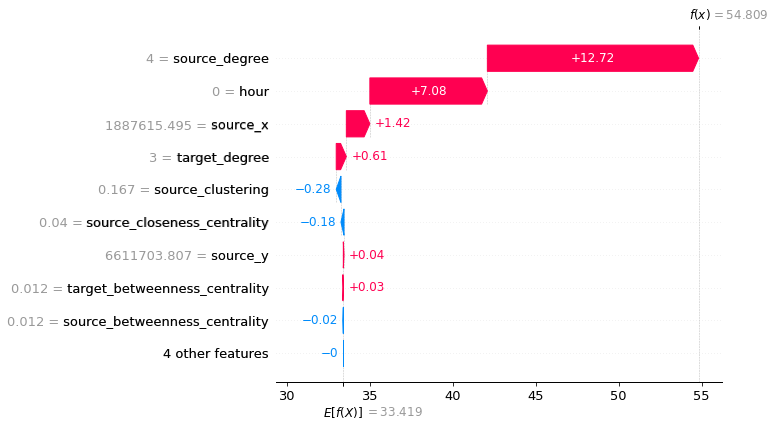

In [142]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])